### X lines of Python

# Wedge model

This is part of [an Agile blog series](http://ageo.co/xlines00) called **x lines of Python**.

We start with the usual preliminaries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

## Make an earth model

We'll start off with an earth model --- an array of 'cells', each of which has some rock properties.

Line 1 sets up some basic variables, then in line 2 I've used a little matrix-forming trick, `np.tri(m, n, k)`, which creates an *m* &times; *n* matrix with ones below the *k*th diagonal, and zeros above it.

Then line 3 just sets every row above `depth//3` (the `//` is integer division, because NumPy prefers integers for indexing arrays), to 0.

In [2]:
length, depth = 40, 100
model = 1 + np.tri(depth, length, -depth//3)
model[:depth//3,:] = 0

We'll have a quick look with some very basic plotting commands.

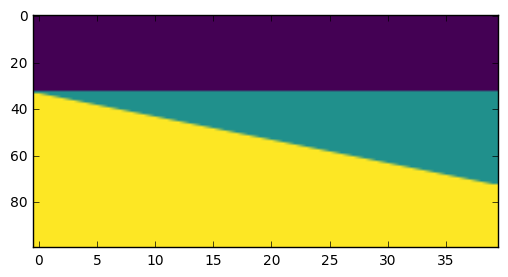

In [4]:
plt.imshow(model, cmap='viridis', aspect=0.2)
plt.show()

Now we can make some Vp-rho pairs (rock 0, rock 1, rock 2) and select from those with `np.take`. This works like `vlookup` in Excel --- it says "read this array, `model` in this case, in which the values *i* are like 0, 1, ... n, and give me the *i*th element from this other array, `rocks` in this case.

The `astype(int)` casts the `model` array to integers, which `take()` requires. And `axis=0` says 'give me the *i*th element from along the first axis (index 0)'. If you don't do this, you get the *i*th element from the array *as if it was flat*, so *i* = 0 would give me `2700`, not `(2700, 2750)`.

In [4]:
rocks = np.array([[2700, 2750],  # Vp, rho
                  [2400, 2450],
                  [2800, 3000]])

earth = np.take(rocks, model.astype(int), axis=0)

Now apply `np.product` to those Vp-rho pairs to get impedance at every sample.

This might look a bit magical, but we're just telling Python to apply the function `product()` to every set of numbers it encounters on the last axis (index `-1`). The array `earth` has shape (100, 40, 2), so you can think of it as a 100 row x 40 column 'section' in which each 'sample' is occupied by a Vp-rho pair. That pair is in the last axis. So product, which just takes a bunch of numbers and multiplies them, will return the impedance (the product of Vp and rho) at each sample location. We'll end up with a new 100 x 40 'section' with impedance at every sample.

In [5]:
imp = np.apply_along_axis(np.product, -1, earth)

We could have saved a step by taking from `np.product(rocks, axis=1)` but I like the elegance of having an earth model with a set of rock properties at each sample location. That's how I think about the earth --- and it's similar to the concept of a geocellular model.

## Model seismic reflections

Now we have an earth model — giving us acoustic impedance everywhere in this 2D grid — we define a function to compute reflection coefficients for every trace.

I love this indexing trick though I admit it looks weird the first time you see it. It's easier to appreciate for a 1D array. Let's look at the differences:

    >>> a = np.array([1,1,1,2,2,2,3,3,3])
    >>> a[1:] - a[:-1]
    array([0, 0, 1, 0, 0, 1, 0, 0])

This is equivalent to:

    >>> np.diff(a)
    
But I prefer to spell it out so it's analogous to the sum on the denominator.

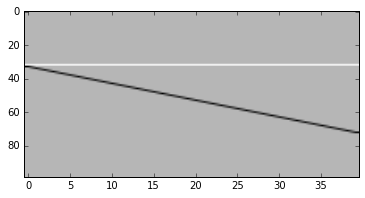

In [6]:
rc =  (imp[1:,:] - imp[:-1,:]) / (imp[1:,:] + imp[:-1,:])

plt.imshow(rc, cmap='Greys', aspect=0.2)
plt.show()

We'll use a wavelet function from [`bruges`](https://github.com/agile-geoscience/bruges). This is not cheating! Well, I don't think it is... we could use `scipy.signal.ricker` but I can't figure out how to convert frequency into the 'width' parameter that function wants. Using the Ricker from `bruges` keeps things a bit simpler.

In [7]:
import bruges

w = bruges.filters.ricker(duration=0.100, dt=0.001, f=40)

Let's make sure it looks OK:

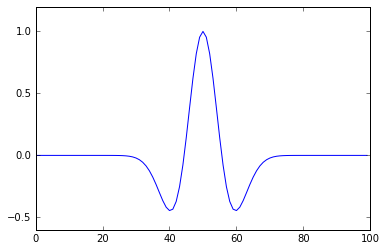

In [8]:
plt.plot(w)
plt.show()

Now one more application of `apply_along_axis`. We could use a loop to step over the traces, but the rule of thumb in Python is "if you are using a loop, you're doing it wrong.". So, we'll use `apply_along_axis`.

It looks a bit more complicated this time, because we can't just pass a function like we did with `product` before. We want to pass in some more things, not just the trace that `apply_along_axis` is going to send it. So we use Python's 'unnamed function creator', `lambda` (in keeping with all things called `lambda`, it's a bad name that no-one can quite explain).

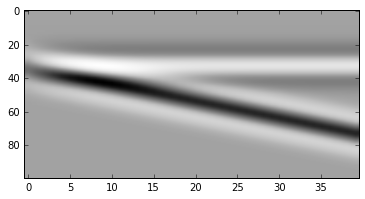

In [9]:
synth = np.apply_along_axis(lambda t: np.convolve(t, w, mode='same'),
                            axis=0,
                            arr=rc)

plt.imshow(synth, cmap="Greys", aspect=0.2)
plt.show()

That's it! And it only needed 9 lines of Python! Not incldung boring old imports and plotting stuff.

Here they are so you can count them:

In [65]:
length, depth = 40, 100
model = 1 + np.tri(depth, length, -depth//3)
model[:depth//3,:] = 0
rocks = np.array([[2700, 2750], [2400, 2450], [2800, 3000]])
earth = np.take(rocks, model.astype(int), axis=0)
imp = np.apply_along_axis(np.product, -1, earth)
rc =  (imp[1:,:] - imp[:-1,:]) / (imp[1:,:] + imp[:-1,:])
w = bruges.filters.ricker(duration=0.100, dt=0.001, f=40)
synth = np.apply_along_axis(lambda t: np.convolve(t, w, mode='same'), axis=0, arr=rc)

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>